In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def init_random(x, k):
    d = int(x.shape[1])
    random_samples = np.random.choice(len(x), k)
    return x[random_samples]

def euc_dist(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

In [3]:
#Plotting functions
def plot_lloyds(x, all_centers=None):
    plt.scatter(x[:, 0], x[:, 1], alpha=0.8, s=10)
    if all_centers:
        colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(all_centers)))
        for i, centers in enumerate(all_centers):
            if i == len(all_centers) - 1:
                m = '*'
            else:
                m = '.'
            if i > 0:
                for j in range(len(centers)):
                    plt.plot(
                        [centers[j][0], all_centers[i-1][j][0]],
                        [centers[j][1], all_centers[i-1][j][1]],
                        linewidth=1,
                        marker=m,
                        markersize=15 * (i+1)/len(all_centers),
                        color=colors[i],
                        markeredgecolor=colors[i],
                    )
    plt.show()
    
def visualize_costs(centers, min_vals, max_vals):
    x_range = np.arange(min_vals[0], max_vals[0])
    y_range = np.arange(min_vals[1], max_vals[1])
    costs = np.zeros((len(x_range), len(y_range)))
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            costs[i, j] = error(np.array([x, y]), centers)

    fig = plt.figure()
    X, Y = np.meshgrid(x_range, y_range)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, costs.T, alpha=0.7)
    in_bounds_centers = (min_vals[0] < centers[:, 0]) * (centers[:, 0] < max_vals[0]) * (min_vals[1] < centers[:, 1]) * (centers[:, 1] < max_vals[1])
    ax.scatter(centers[in_bounds_centers, 0], centers[in_bounds_centers, 1], np.zeros(np.sum(in_bounds_centers)), c='r', marker='*')
    plt.show()

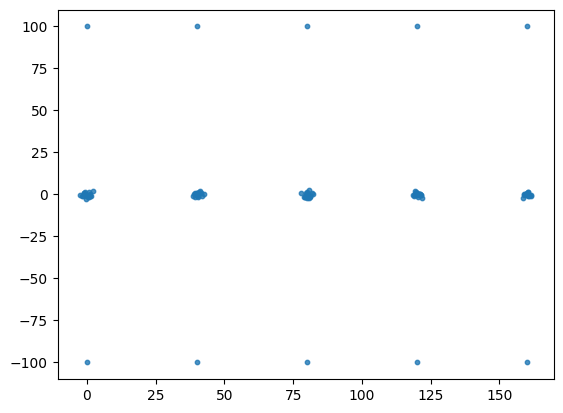

In [4]:
np.random.seed(123)
def create_artificial_bad_dataset(n, k=15, vert_spacing=100, horiz_spacing=None):
    """
    Create a dataset of k clusters where 1/3 of the clusters have O(n) points.
    The other clusters each have size O(1).
    Lloyd's algorithm will perform arbitrarily poorly on this dataset.
    """
    if k % 3 != 0:
        raise ValueError("Artificial bad dataset needs k to be divisible by 3")
    if horiz_spacing is None:
        horiz_spacing = 6 * vert_spacing / k
    
    # assume dimensionality is 2 so it's easy to plot
    points = np.zeros((n, 2))
    for column in range(int(k/3)):
        x = horiz_spacing * column
        points[int(column * 3 * n / k)] = [column * horiz_spacing, vert_spacing]
        points[int((column+1) * 3 * n / k - 1)] = [column * horiz_spacing, -vert_spacing]
        points[int(column * 3 * n / k + 1) : int((column+1) * 3 * n / k - 1)] = np.random.multivariate_normal([column * horiz_spacing, 0], [[1, 0], [0, 1]], [int(3 * n / k - 2)]) 
        
    return points

plot_lloyds(create_artificial_bad_dataset(100))

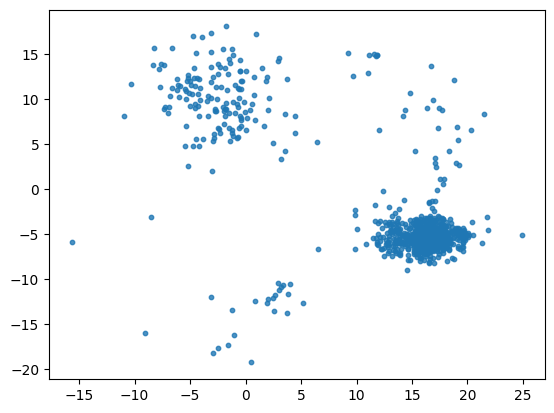

In [5]:
def create_hierarchical_clusters(n, point=None, std_dev=100, d=2, recur_likelihood=1.0):
    """
    Create a dataset that samples from a Gaussian distribution.
    For each sample, recursively sample points from its neighborhood with some likelihood.
    In expectation, this creates a normally distributed ball of Gaussian clusters where each cluster likely has sub-clusters within it.
    """
    if point is None:
        point = np.zeros(d)
    if n <= 1:
        return np.random.multivariate_normal(point, np.eye(d) * std_dev, 1)
    
    points = []
    points_remaining = n
    i = 0
    while points_remaining > 1:
        subcluster_size = int(np.random.uniform() * points_remaining)
        if np.random.uniform() < recur_likelihood:
            subcluster_mean = np.random.multivariate_normal(point, np.eye(d) * std_dev)
            subcluster = create_hierarchical_clusters(
                n=subcluster_size,
                point=subcluster_mean,
                std_dev=std_dev/10,
                d=d,
                recur_likelihood=recur_likelihood * np.random.uniform()
            )
        else:
            subcluster = np.random.multivariate_normal(point, np.eye(d) * std_dev, subcluster_size)
        points.append(subcluster)
        points_remaining -= subcluster_size
            
    if points:
        points = np.concatenate(points, axis=0)
        if len(points) > n:
            points = points[np.random.choice(len(points), n)]
        return points
    return np.empty([0, d])

plot_lloyds(create_hierarchical_clusters(1000, d=2))

In [6]:
# TO DO BY STUDENTS

def get_assignments(points, centers):
    assignments = -1 * np.ones(len(points))
    for i, point in enumerate(points):
        min_dist = np.inf
        closest_center = None
        for j, center in enumerate(centers):
            point_center_dist = euc_dist(point, center)
            if point_center_dist < min_dist:
                min_dist = point_center_dist
                closest_center = j
        assignments[i] = closest_center
    return assignments.astype(np.int32)

def error(points, centers):
    assignments = get_assignments(points, centers)
    cost = 0
    for i, point in enumerate(points):
        cost += np.square(euc_dist(point, centers[assignments[i]]))
        
    return cost

def lloyds_step(points, centers):
    # Get all cluster assignments given x and c
    n, d = points.shape
    k = centers.shape[0]
    assignments = get_assignments(points, centers)
    
    # Assign new centers to the means of the clusters
    new_centers = np.zeros((k, d))
    for c in range(len(centers)):
        point_inds = np.where(assignments == c)
        new_centers[c] = np.mean(x[point_inds], axis=0)
        
    return new_centers

In [7]:
# TO DO BY STUDENTS
def lloyds(x, k, init, tol=1e-8, max_steps=1000, loud=True):
    all_centers = [init(x, k)]
    step = 0
    cost = error(x, all_centers[-1])
    loss_change = np.inf
    while loss_change > tol and step < max_steps:
        all_centers.append(lloyds_step(x, all_centers[-1]))
        new_cost = error(x, all_centers[-1])
        loss_change = cost - new_cost
        cost = new_cost
        step += 1
        if loud:
            print(cost)
        
    return all_centers

400.9619809494981
364.4477231087809
347.2967187046363
336.3190003440703
324.9830703208014
286.6826842841979
270.7325487314052
269.35588158814295
268.16634809209677
267.45326563882384
267.10947441863067
266.8670099514765
266.7355765844089
266.7355765844089


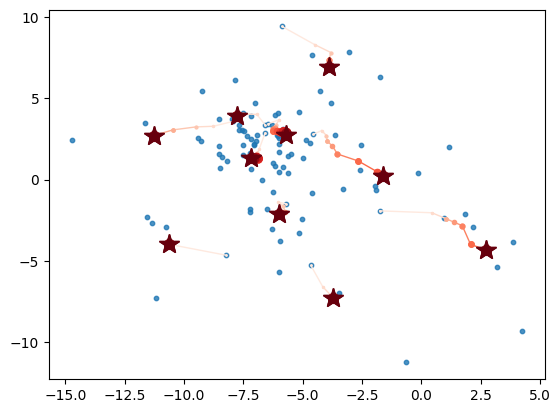

Here is a look at the cost of a point over the input space:


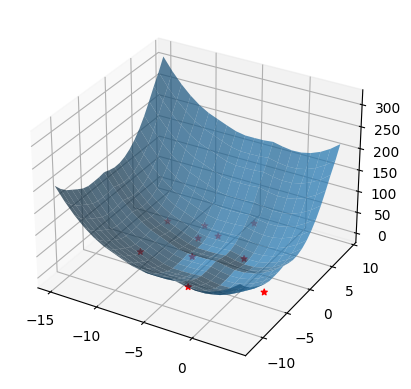

Now let's zoom in on the middle 50 percent of points:


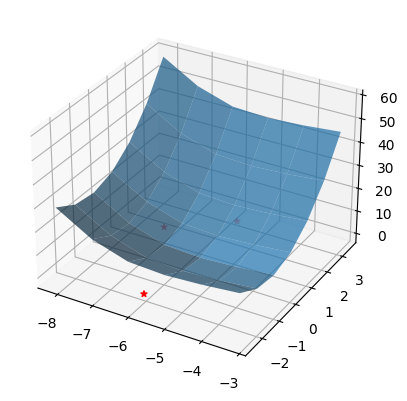

In [8]:
x = create_hierarchical_clusters(100)
all_centers = lloyds(x, 10, init_random)
plot_lloyds(x, all_centers)

print('Here is a look at the cost of a point over the input space:')
visualize_costs(
    all_centers[-1],
    [np.floor(np.min(x[:, 0])), np.floor(np.min(x[:, 1]))],
    [np.ceil(np.max(x[:, 0])), np.ceil(np.max(x[:, 1]))],
)

print('Now let\'s zoom in on the middle 50 percent of points:')
visualize_costs(
    all_centers[-1],
    [np.percentile(x[:, 0], 15), np.percentile(x[:, 1], 15)],
    [np.percentile(x[:, 0], 85), np.percentile(x[:, 1], 85)],
)

/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


53376.1651869012
11838.311070958025
8143.051141974391
8142.285230018587
8142.285230018587


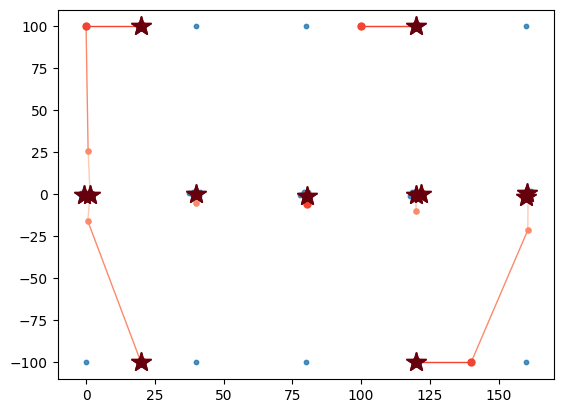

In [9]:
k = 15
x = create_artificial_bad_dataset(100, k)
all_centers = lloyds(x, k, init_random)
plot_lloyds(x, all_centers)

In [10]:
# TODO BY STUDENTS

def get_min_dists_to_centers(points, new_center, dists):
    if dists is None:
        dists = np.ones((len(points))) * np.inf
    if len(new_center.shape) == 1:
        new_center = np.expand_dims(new_center, axis=0)
    new_dists = np.sum((points - new_center) ** 2, axis=-1)
    improved_inds = new_dists < dists
    dists[improved_inds] = new_dists[improved_inds]
    return dists

def init_kmeans_plusplus(points, k):
    n, d = int(points.shape[0]), int(points.shape[1])
    centers = [np.random.choice(n)]
    sq_dists = None
    for i in range(k-1):
        sq_dists = get_min_dists_to_centers(points, points[np.array(centers)[-1]], sq_dists)
        if np.sum(sq_dists) > 0:
            probs = sq_dists / np.sum(sq_dists)
        else:
            probs = np.ones_like(probs) / len(probs)
        centers.append(np.random.choice(n, p=probs))
    return points[centers]

626.6509902614232
598.1551388239296
588.9722367013859
586.7776324562525
582.5519883457071
565.3678974077507
558.8756138989432
558.8756138989432


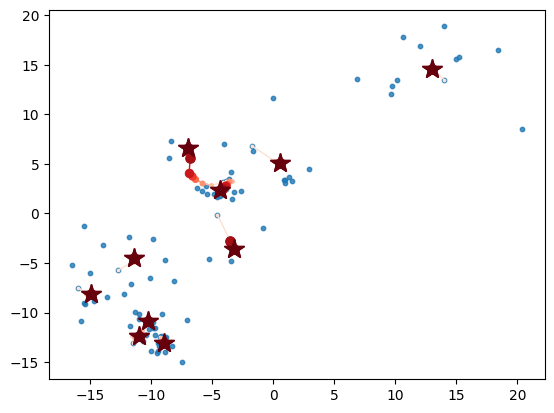

460.3034527960421
438.0305104539609
435.96179179605906
435.96179179605906


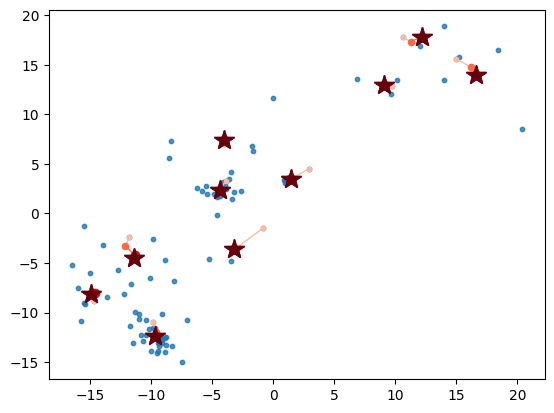

In [11]:
x = create_hierarchical_clusters(100)

all_centers = lloyds(x, 10, init_random)
plot_lloyds(x, all_centers)

all_centers = lloyds(x, 10, init_kmeans_plusplus)
plot_lloyds(x, all_centers)

59194.762844169076
19162.81869003393
19161.917010409248
19161.917010409248


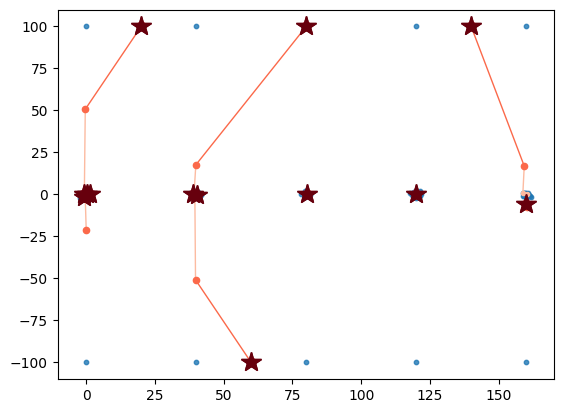

155.42653009341004
155.42653009341004


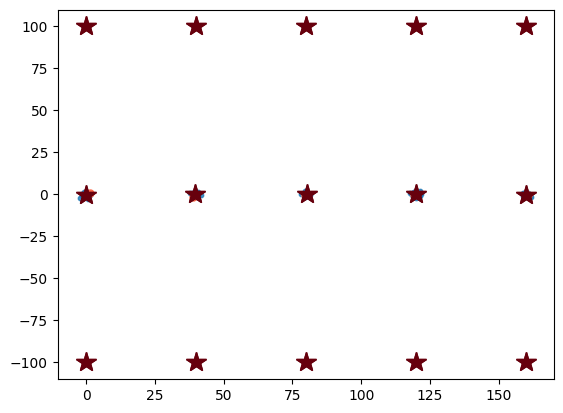

In [12]:
x = create_artificial_bad_dataset(100)

all_centers = lloyds(x, 15, init_random)
plot_lloyds(x, all_centers)

all_centers = lloyds(x, 15, init_kmeans_plusplus)
plot_lloyds(x, all_centers)

In [13]:
# Look at runtime distribution for Lloyds and KMeans++ with and without JL
from time import time
from sklearn.random_projection import SparseRandomProjection
n, d, k = 200, 1000, 20
num_experiments = 5
times = np.zeros((3, num_experiments))
costs = np.zeros((3, num_experiments))

print('Experiment iteration counter:')
JL = SparseRandomProjection(20)
for i in range(num_experiments):
    print('{}...'.format(i))
    x = create_hierarchical_clusters(n, d=d)
    start = time()
    all_centers = lloyds(x, k, init_random, loud=False)
    end = time()
    times[0, i] = end - start
    costs[0, i] = error(x, all_centers[-1])

    start = time()
    all_centers = lloyds(x, k, init_kmeans_plusplus, loud=False)
    end = time()
    times[1, i] = end - start
    costs[1, i] = error(x, all_centers[-1])

    start = time()
    x = JL.fit_transform(x)
    all_centers = lloyds(x, k, init_kmeans_plusplus, loud=False)
    end = time()
    times[2, i] = end - start
    costs[2, i] = error(x, all_centers[-1])
    
print('Random init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[0]), np.var(times[0]), np.mean(costs[0]), np.var(costs[0])))
print('kmeans++ init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[1]), np.var(times[1]), np.mean(costs[1]), np.var(costs[1])))
print('JL and kmeans++ init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[2]), np.var(times[2]), np.mean(costs[2]), np.var(costs[2])))

Experiment iteration counter:
0...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


2...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


3...
4...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Random init --- time: 0.234 +/- 0.001; cost: 1281619.069
kmeans++ init --- time: 0.226 +/- 0.002; cost: 809589.855
JL and kmeans++ init --- time: 0.383 +/- 0.009; cost: 649444.906
